In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [17]:
df = pd.read_csv("../data/processed/insurance_feature_engineered.csv")

# IMPORTANT: drop any leftover raw categorical columns if present
cols_to_drop = [c for c in ["charges", "log_charges"] if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df["log_charges"]

# If any raw columns slipped in, drop them
raw_cols = ["sex", "smoker", "region", "age_group", "bmi_category"]
X = X.drop(columns=[c for c in raw_cols if c in X.columns], errors="ignore")


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
# Align X_test to match training columns expected by the model
expected_cols = model.feature_names_in_
X_test_aligned = X_test.reindex(columns=expected_cols, fill_value=0)

preds = model.predict(X_test_aligned)
preds[:5]


array([ 9.20259668,  8.60361745, 10.30844737,  9.17758619, 10.3942519 ])

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


MAE: 0.1850274948652931
RMSE: 0.3466181355655831
R2: 0.8663789362894823


The Gradient Boosting model achieves strong predictive performance on unseen data, explaining a large portion of variance in log-transformed medical charges.

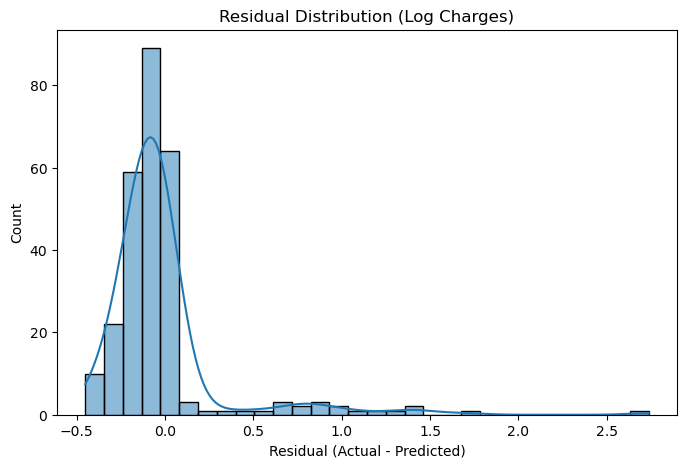

In [31]:
residuals = y_test - preds

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution (Log Charges)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


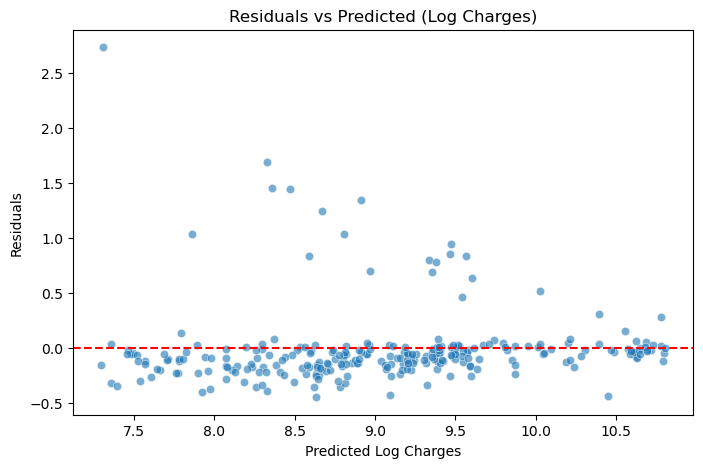

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=preds, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (Log Charges)")
plt.xlabel("Predicted Log Charges")
plt.ylabel("Residuals")
plt.show()


Errors tend to increase slightly at higher predicted costs, which is typical in healthcare where extreme spend is harder to predict.

In [33]:
actual_cost = np.exp(y_test)
pred_cost = np.exp(preds)

comparison = pd.DataFrame({
    "Actual_Cost": actual_cost,
    "Predicted_Cost": pred_cost
})

comparison.head()


,Actual_Cost,Predicted_Cost
764,9095.06825,9922.862107
887,5272.17580,5451.343941
890,29330.98315,29984.845199
1293,9301.89355,9677.764234
259,33750.29180,32671.287036


In [34]:
threshold = actual_cost.quantile(0.80)
high_mask = actual_cost >= threshold

high_mae = mean_absolute_error(actual_cost[high_mask], pred_cost[high_mask])
print("High-cost (top 20%) MAE in $:", high_mae)


High-cost (top 20%) MAE in $: 5624.573543680827


Prediction error is larger among high-cost members, which is expected given the complexity and variability of extreme healthcare spending. The model still captures overall cost stratification effectively.

In [35]:
importances = pd.DataFrame({
    "feature": expected_cols,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(10)


,feature,importance
4,smoker_bmi_interaction,0.414243
0,age,0.395047
3,smoker_flag,0.093696
2,children,0.039753
1,bmi,0.032846
12,bmi_category_obese,0.011864
5,sex_male,0.005111
8,region_southwest,0.003825
7,region_southeast,0.001459
6,region_northwest,0.000941


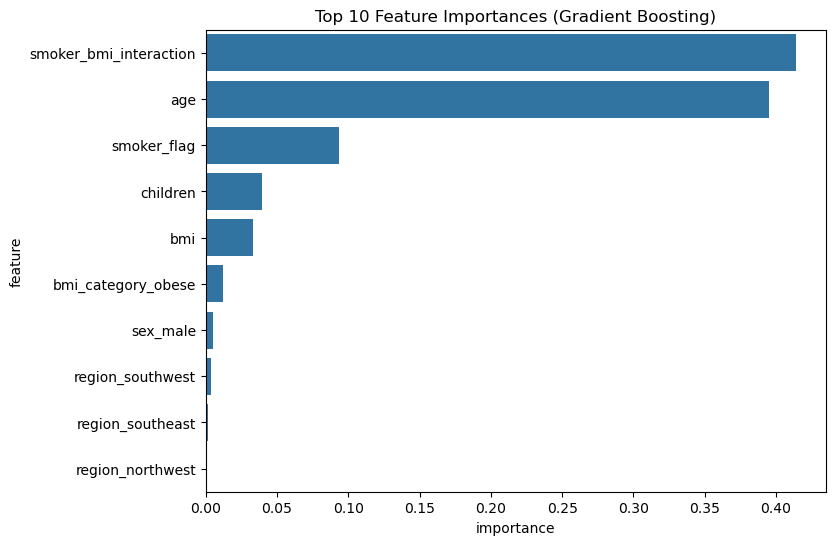

In [36]:
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.show()


The model identifies smoking-related risk, particularly when combined with high BMI, as the dominant driver of healthcare costs. Age remains a strong predictor, while geographic region contributes relatively little variance. This aligns with established healthcare risk stratification patterns.



Evaluation Summary
The final Gradient Boosting model demonstrates strong predictive performance, explaining approximately 87% of the variance in log-transformed medical costs. Residual analysis shows no significant systematic bias, though prediction error increases modestly for high-cost members, which is expected given the complexity of extreme healthcare spending. Feature importance analysis highlights smoking-related risk and BMI as the most influential cost drivers, followed by age, while regional factors contribute minimally. These results align with known healthcare utilization patterns and support the model’s practical relevance for cost forecasting and risk stratification.

Limitations
This project is based on a simplified insurance cost dataset and does not include detailed claims history, diagnoses, procedures, pharmacy data, or longitudinal utilization patterns. As a result, the model may underperform in predicting extreme high-cost cases compared to models trained on full claims data.